In [1]:
import pandas as pd

df = pd.DataFrame({
    'team':['Germany','USA','France','Japan','Sweden','England','Brazil','Canada','Australia','Norway','Netherlands','Spain',
           'China','New Zealand','South Korea','Switzerland','Mexico','Colombia','Thailand','Nigeria','Ecuador','Ivory Coast','Cameroon','Costa Rica'],
    'group':['B','D','F','C','D','F','E','A','D','B','A','E','A','A','E','C','F','F','B','D','C','B','C','E'],
    'fifascore':[2168,2158,2103,2066,2008,2001,1984,1969,1968,1933,1919,1867,1847,1832,1830,1813,1748,1692,1651,1633,1485,1373,1455,1589],
    'ftescore':[95.6,95.4,92.4,92.7,91.6,89.6,92.2,90.1,88.7,88.7,86.2,84.7,85.2,82.5,84.3,83.7,81.1,78.0,68.0,85.7,63.3,75.6,79.3,72.8]
    })

df.groupby(['group', 'team']).mean()

fifascore  ftescore
group team                            
A     Canada            1969      90.1
      China             1847      85.2
      Netherlands       1919      86.2
      New Zealand       1832      82.5
B     Germany           2168      95.6
      Ivory Coast       1373      75.6
      Norway            1933      88.7
      Thailand          1651      68.0
C     Cameroon          1455      79.3
      Ecuador           1485      63.3
      Japan             2066      92.7
      Switzerland       1813      83.7
D     Australia         1968      88.7
      Nigeria           1633      85.7
      Sweden            2008      91.6
      USA               2158      95.4
E     Brazil            1984      92.2
      Costa Rica        1589      72.8
      South Korea       1830      84.3
      Spain             1867      84.7
F     Colombia          1692      78.0
      England           2001      89.6
      France            2103      92.4
      Mexico            1748      81.1

In [2]:
df.index = df.team
df.describe()
#using 220 as std for fifascore, 84 for ftescore

,fifascore,ftescore
count,24.000000,24.00000
mean,1837.166667,84.47500
std,220.425018,8.34627
min,1373.000000,63.30000
25%,1681.750000,80.65000
50%,1857.000000,85.45000
75%,1988.250000,90.47500
max,2168.000000,95.60000


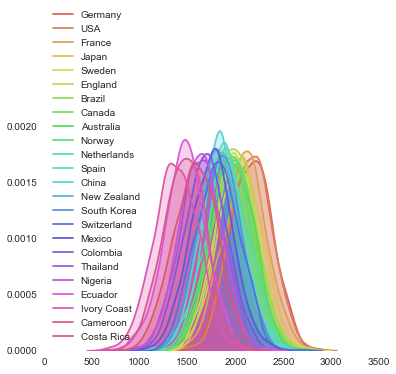

In [11]:
import scipy.stats as stats
import seaborn as sns
%matplotlib inline

pal = sns.color_palette('hls', len(df))

for i, c in zip(range(len(df)), pal):        
    normdist = stats.norm(df.fifascore[i], 220)
    sns.kdeplot(normdist.rvs(1000), shade=True, label=df.team[i], color=c)

In [13]:
import montecarlo

fifa = montecarlo.mc('fifascore', 200)
fifa.run_sim()
fte = montecarlo.mc('ftescore', 200)
fte.run_sim()

fifadf = pd.concat(fifa.total_score, axis=1)
ftedf = pd.concat(fte.total_score, axis=1)

result = pd.concat([fifadf.mean(axis=1), ftedf.mean(axis=1)], axis=1)
result.columns = ['fifascore', 'ftescore']

montecarlo.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  thirds['grouprk'] = rank_tb(thirds.score)


In [14]:
result.sort('ftescore')

,fifascore,ftescore
Ecuador,2.095,0.990
Thailand,2.640,1.395
Costa Rica,2.295,1.810
Ivory Coast,1.205,2.485
Colombia,2.335,2.490
Mexico,3.055,3.025
Nigeria,1.790,3.290
New Zealand,3.835,3.385
South Korea,3.910,3.865
China,3.745,3.900


In [15]:
result.sort('fifascore')

,fifascore,ftescore
Ivory Coast,1.205,2.485
Nigeria,1.790,3.290
Ecuador,2.095,0.990
Cameroon,2.120,3.905
Costa Rica,2.295,1.810
Colombia,2.335,2.490
Thailand,2.640,1.395
Mexico,3.055,3.025
China,3.745,3.900
New Zealand,3.835,3.385


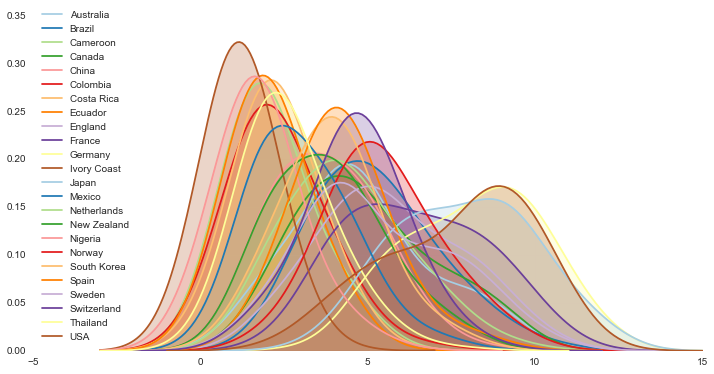

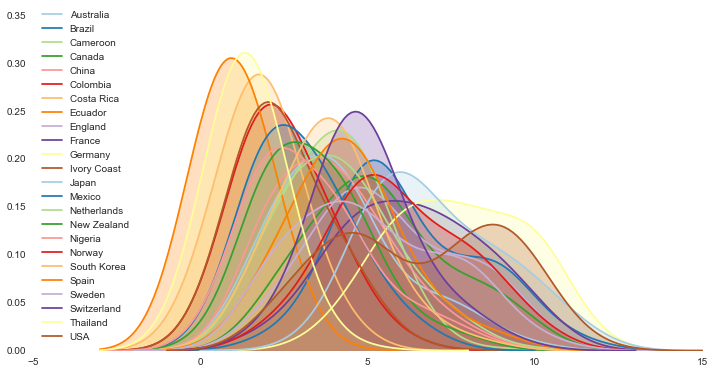

In [19]:
import matplotlib.pyplot as plt
pal = sns.color_palette('Paired', n_colors=len(fifadf))

plt.figure(figsize=(12,6))
for i, c in zip(fifadf.T, pal):
    sns.kdeplot(fifadf.T[i], bw=1, label=i, color=c, shade=True)

plt.figure(figsize=(12,6))
for i, c in zip(ftedf.T, pal):
    sns.kdeplot(ftedf.T[i], bw=1, label=i, color=c, shade=True)    